# Data Cleaning

In [92]:
import os
from PIL import Image
import torch
import numpy as np
from tqdm import tqdm
def psnr(img1, img2, max_pixel=255.0):
    mse = np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(max_pixel / np.sqrt(mse))

train_color_dir = "data_kaggle/data/train/placeholder/images/"
grayscale_images = []

psnr_threshold = 42  # PSNR above this means the image is "grayscalish"

for fname in tqdm(list(os.listdir(train_color_dir))):
    fpath = os.path.join(train_color_dir, fname)
    try:
        img = Image.open(fpath)
        if img.mode == 'L':
            grayscale_images.append(fname)
        elif img.mode in ['RGB', 'RGBA']:
            img_rgb = img.convert('RGB')
            arr = np.array(img_rgb)
            # Create a grayscale version and stack to 3 channels
            arr_gray = np.array(img_rgb.convert('L'))
            arr_gray3 = np.stack([arr_gray]*3, axis=-1)
            # Compute PSNR between original and "grayscale" version
            score = psnr(arr, arr_gray3)
            if score >= psnr_threshold:
                grayscale_images.append(fname)
    except Exception as e:
        print(f"Error reading {fname}: {e}")

print(f"Grayscale images (PSNR threshold={psnr_threshold}): {grayscale_images}")
print(f"Number of grayscale images: {len(grayscale_images)}")


100%|██████████| 36398/36398 [01:11<00:00, 506.36it/s]

Grayscale images (PSNR threshold=42): ['Coast-Train (1857).jpeg', 'Coast-Train (787).jpeg', 'Coast-Train (224).jpeg', 'Glacier-Train (1913).jpeg', 'Glacier-Train (733).jpeg', 'Coast-Train (827).jpeg', 'Coast-Train (533).jpeg', 'Coast-Train (558).jpeg', 'Coast-Train (1385).jpeg']
Number of grayscale images: 9


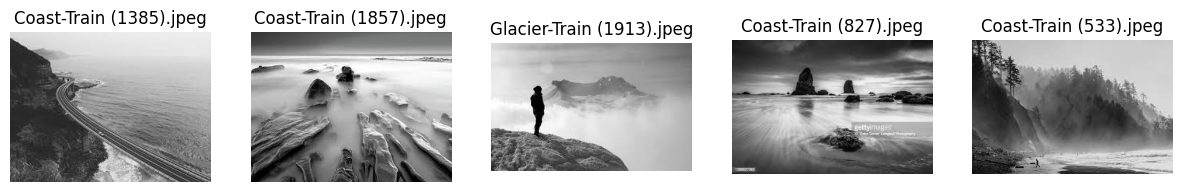

In [93]:
import matplotlib.pyplot as plt
import random

# Randomly select up to 5 grayscale images
num_to_show = min(5, len(grayscale_images))
random_imgs = random.sample(grayscale_images, num_to_show) if num_to_show > 0 else []

fig, axs = plt.subplots(1, num_to_show, figsize=(15, 3))
if num_to_show == 1:
    axs = [axs]
for i, fname in enumerate(random_imgs):
    img_path = os.path.join(train_color_dir, fname)
    img = Image.open(img_path)
    axs[i].imshow(img, cmap='gray' if img.mode == 'L' else None)
    axs[i].set_title(fname)
    axs[i].axis('off')
plt.show()


In [94]:
# Remove all grayscale images from the directory
for fname in grayscale_images:
    fpath = os.path.join(train_color_dir, fname)
    try:
        os.remove(fpath)
        print(f"Removed grayscale image: {fname}")
    except Exception as e:
        print(f"Error removing {fname}: {e}")


Removed grayscale image: Coast-Train (1857).jpeg
Removed grayscale image: Coast-Train (787).jpeg
Removed grayscale image: Coast-Train (224).jpeg
Removed grayscale image: Glacier-Train (1913).jpeg
Removed grayscale image: Glacier-Train (733).jpeg
Removed grayscale image: Coast-Train (827).jpeg
Removed grayscale image: Coast-Train (533).jpeg
Removed grayscale image: Coast-Train (558).jpeg
Removed grayscale image: Coast-Train (1385).jpeg


# Loading Model

In [2]:
from train.trainer import MyTrainer
from utils.config import TrainingArgs
import torch

config = TrainingArgs(
    epochs=12,
    batch_size=16,
    image_size=128,
    device="cpu",
    data_path="data_kaggle/data",
    generator__init__args={'interpolation_mode': 'bilinear'},
    discriminator__init__args={'in_channels': 4, 
                                'base': 64, 
                                'spectral': False},
    generator_lr=0.0001,
    discriminator_lr=0.0001,
    generator_beta1=0.0,
    generator_beta2=0.9,
    discriminator_beta1=0.0,
    discriminator_beta2=0.9,
    lambda_gp=10,
    lambda_l1=100,
    lambda_l1_low=100,
    lambda_mode_seeking=1,
    lambda_mode_seeking_low=1,
    critic_n=5,
    val_freq=10,
    log_dir='logs_big_images_final_v5_tmp',
    accumulation_steps=4,
)
# Create the trainer
trainer = MyTrainer(config)

In [ ]:
import torch
generator_path = "generator_epoch_11.pth"

trainer.generator.load_state_dict(torch.load(generator_path))

<All keys matched successfully>

# Testing on B&W images 

In [150]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# Load image in grayscale
img = Image.open('test.jpg')

# Compose transforms: ToTensor, Resize, Normalize
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

img_tensor = transform(img)  # shape: [1, 512, 512]
img_tensor = transforms.functional.rgb_to_grayscale(img_tensor, num_output_channels=1)
# Add batch dimension
img_tensor = img_tensor.unsqueeze(0)  # shape: [1, 1, 512, 512]

img_tensor.shape


torch.Size([1, 1, 512, 512])

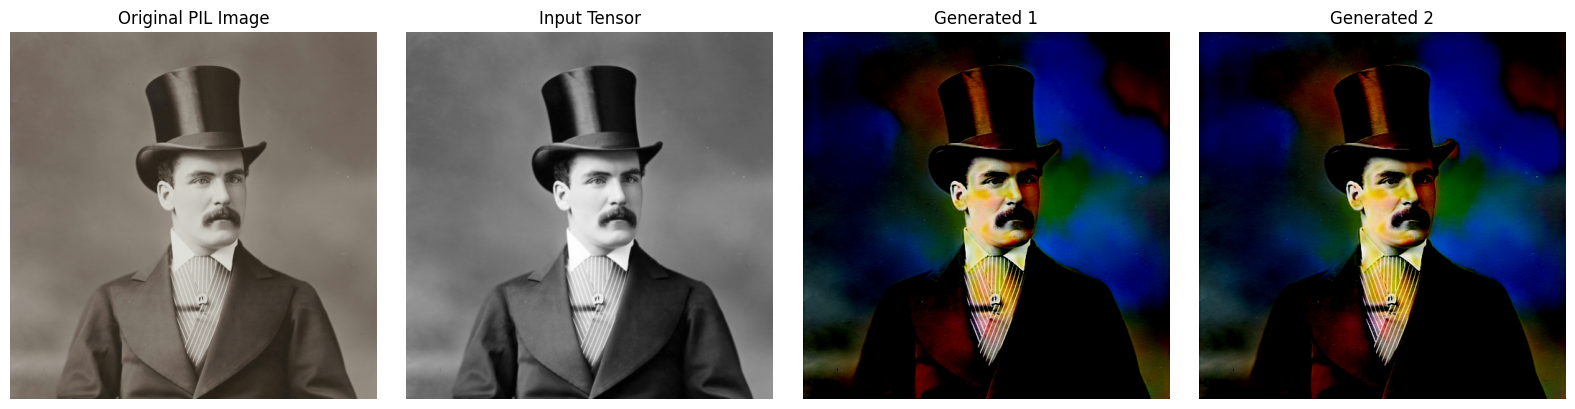

In [151]:
import random
import matplotlib.pyplot as plt
import numpy as np
gen_images = []
n=2
for _ in range(n):
    z = trainer.generate_z(img_tensor.shape[0], 128)
    with torch.no_grad():
        gen_img = trainer.generator(img_tensor.to(trainer.device), z)
    gen_images.append(gen_img.squeeze(0).cpu())

# Display the original PIL image, the normalized tensor, and the generated results
fig, axes = plt.subplots(1, n + 2, figsize=(4 * (n + 2), 4))

# Show original PIL image
axes[0].imshow(img, cmap='gray')
axes[0].set_title("Original PIL Image")
axes[0].axis('off')

# Show normalized tensor image (convert back to [0,1] for display)
img_tensor_disp = img_tensor.squeeze().cpu() * 0.5 + 0.5
axes[1].imshow(img_tensor_disp.numpy(), cmap='gray')
axes[1].set_title("Input Tensor")
axes[1].axis('off')

# Show generated images
for i, gen_img in enumerate(gen_images):
    # Clamp and permute for display
    img_disp = gen_img.clamp(0, 1)
    if img_disp.ndim == 3 and img_disp.shape[0] in [1, 3]:
        img_disp = img_disp.permute(1, 2, 0).numpy()
        if img_disp.shape[2] == 1:
            img_disp = img_disp.squeeze(2)
            axes[i + 2].imshow(img_disp, cmap='gray')
        else:
            axes[i + 2].imshow(img_disp)
    else:
        axes[i + 2].imshow(img_disp.numpy(), cmap='gray')
    axes[i + 2].set_title(f"Generated {i+1}")
    axes[i + 2].axis('off')

plt.tight_layout()
plt.show()



In [148]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# Load image in grayscale
img = Image.open('test2.jpg')

# Compose transforms: ToTensor, Resize, Normalize
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

img_tensor = transform(img)  # shape: [1, 512, 512]
img_tensor = transforms.functional.rgb_to_grayscale(img_tensor, num_output_channels=1)
# Add batch dimension
img_tensor = img_tensor.unsqueeze(0)  # shape: [1, 1, 512, 512]

img_tensor.shape


torch.Size([1, 1, 256, 256])

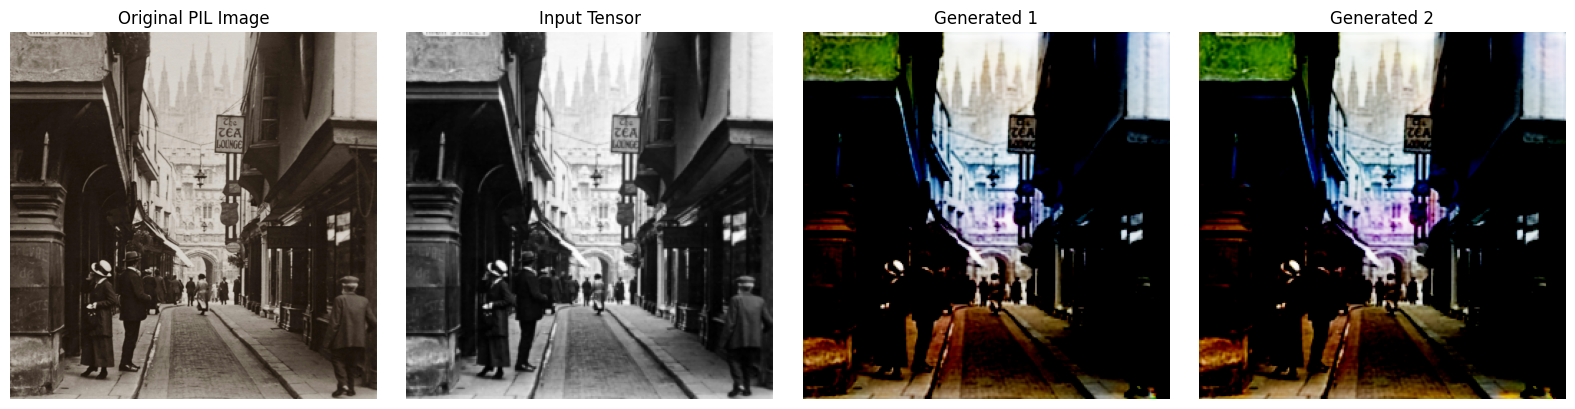

In [149]:
import random
import matplotlib.pyplot as plt
import numpy as np
gen_images = []
n=2
for _ in range(n):
    z = trainer.generate_z(img_tensor.shape[0], 128)
    with torch.no_grad():
        gen_img = trainer.generator(img_tensor.to(trainer.device), z)
    gen_images.append(gen_img.squeeze(0).cpu())

# Display the original PIL image, the normalized tensor, and the generated results
fig, axes = plt.subplots(1, n + 2, figsize=(4 * (n + 2), 4))

# Show original PIL image
axes[0].imshow(img, cmap='gray')
axes[0].set_title("Original PIL Image")
axes[0].axis('off')

# Show normalized tensor image (convert back to [0,1] for display)
img_tensor_disp = img_tensor.squeeze().cpu() * 0.5 + 0.5
axes[1].imshow(img_tensor_disp.numpy(), cmap='gray')
axes[1].set_title("Input Tensor")
axes[1].axis('off')

# Show generated images
for i, gen_img in enumerate(gen_images):
    # Clamp and permute for display
    img_disp = gen_img.clamp(0, 1)
    if img_disp.ndim == 3 and img_disp.shape[0] in [1, 3]:
        img_disp = img_disp.permute(1, 2, 0).numpy()
        if img_disp.shape[2] == 1:
            img_disp = img_disp.squeeze(2)
            axes[i + 2].imshow(img_disp, cmap='gray')
        else:
            axes[i + 2].imshow(img_disp)
    else:
        axes[i + 2].imshow(img_disp.numpy(), cmap='gray')
    axes[i + 2].set_title(f"Generated {i+1}")
    axes[i + 2].axis('off')

plt.tight_layout()
plt.show()



In [154]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# Load image in grayscale
img = Image.open('test3.jpg')

# Compose transforms: ToTensor, Resize, Normalize
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

img_tensor = transform(img)  # shape: [1, 512, 512]
img_tensor = transforms.functional.rgb_to_grayscale(img_tensor, num_output_channels=1)
# Add batch dimension
img_tensor = img_tensor.unsqueeze(0)  # shape: [1, 1, 512, 512]

img_tensor.shape


torch.Size([1, 1, 256, 256])

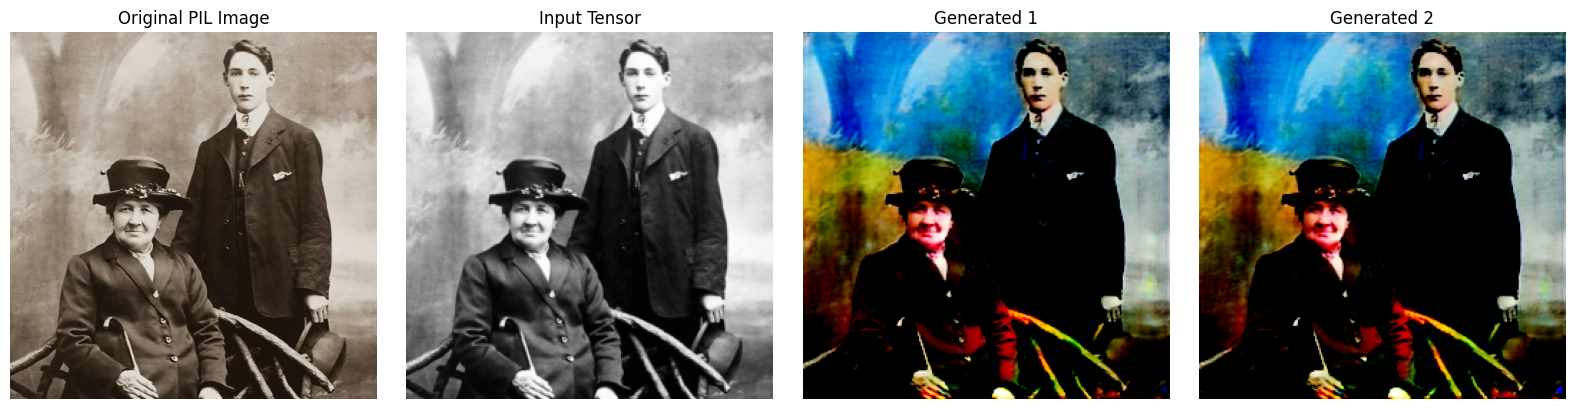

In [155]:
import random
import matplotlib.pyplot as plt
import numpy as np
gen_images = []
n=2
for _ in range(n):
    z = trainer.generate_z(img_tensor.shape[0], 128)
    with torch.no_grad():
        gen_img = trainer.generator(img_tensor.to(trainer.device), z)
    gen_images.append(gen_img.squeeze(0).cpu())

# Display the original PIL image, the normalized tensor, and the generated results
fig, axes = plt.subplots(1, n + 2, figsize=(4 * (n + 2), 4))

# Show original PIL image
axes[0].imshow(img, cmap='gray')
axes[0].set_title("Original PIL Image")
axes[0].axis('off')

# Show normalized tensor image (convert back to [0,1] for display)
img_tensor_disp = img_tensor.squeeze().cpu() * 0.5 + 0.5
axes[1].imshow(img_tensor_disp.numpy(), cmap='gray')
axes[1].set_title("Input Tensor")
axes[1].axis('off')

# Show generated images
for i, gen_img in enumerate(gen_images):
    # Clamp and permute for display
    img_disp = gen_img.clamp(0, 1)
    if img_disp.ndim == 3 and img_disp.shape[0] in [1, 3]:
        img_disp = img_disp.permute(1, 2, 0).numpy()
        if img_disp.shape[2] == 1:
            img_disp = img_disp.squeeze(2)
            axes[i + 2].imshow(img_disp, cmap='gray')
        else:
            axes[i + 2].imshow(img_disp)
    else:
        axes[i + 2].imshow(img_disp.numpy(), cmap='gray')
    axes[i + 2].set_title(f"Generated {i+1}")
    axes[i + 2].axis('off')

plt.tight_layout()
plt.show()



# Sample from my validation

In [160]:
import random
import matplotlib.pyplot as plt
import numpy as np

n = 2 # Number of times to generate with random z
val_batches = list(trainer.val_loader)
batch = random.choice(val_batches)

images = batch['image'].to(trainer.device)
targets = batch['target'].to(trainer.device)


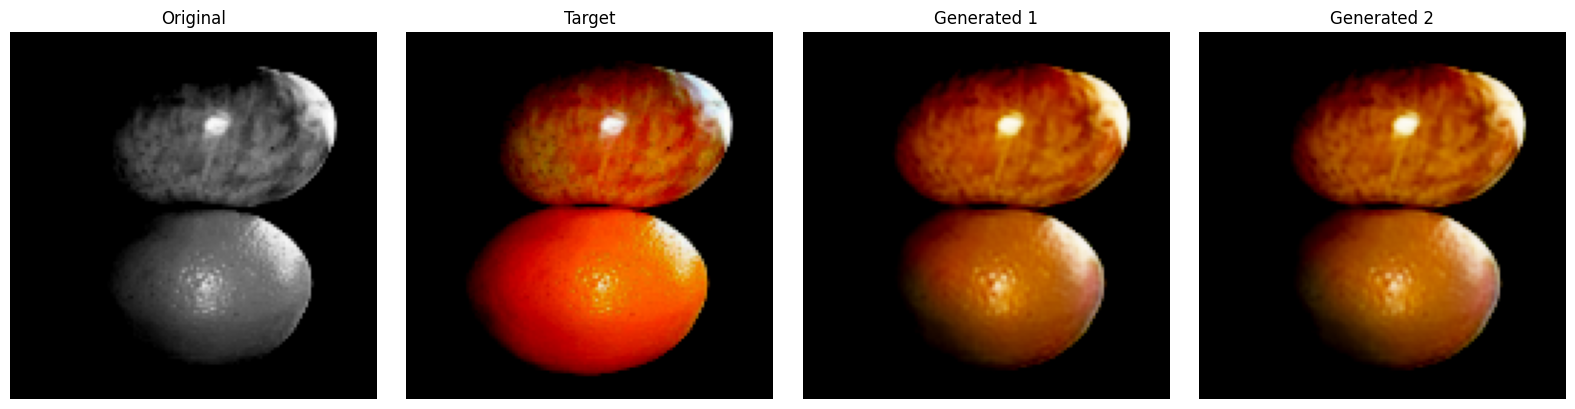

In [161]:
# We'll visualize only the first image in the batch for clarity
img_idx = 0

# Store n generated images for the same input
gen_images = []
for _ in range(n):
    z = trainer.generate_z(images.shape[0], 128)
    generated_images = trainer.generator(images, z).detach().cpu()
    gen_images.append(generated_images[img_idx])

original_image = images[img_idx].detach().cpu()
target_image = targets[img_idx].detach().cpu()

# Plot: Original | Target | n generated
fig, axes = plt.subplots(1, n + 2, figsize=(4 * (n + 2), 4))

# Original
img = original_image.clamp(0, 1)
np_img = img.permute(1, 2, 0).numpy()
if np_img.shape[2] == 1:
    np_img = np_img.squeeze(2)
    axes[0].imshow(np_img, cmap='gray')
else:
    axes[0].imshow(np_img)
axes[0].set_title("Original")
axes[0].axis('off')

# Target
img = target_image.clamp(0, 1)
np_img = img.permute(1, 2, 0).numpy()
if np_img.shape[2] == 1:
    np_img = np_img.squeeze(2)
    axes[1].imshow(np_img, cmap='gray')
else:
    axes[1].imshow(np_img)
axes[1].set_title("Target")
axes[1].axis('off')

# n generated
for i, gen_img in enumerate(gen_images):
    img = gen_img.clamp(0, 1)
    np_img = img.permute(1, 2, 0).numpy()
    if np_img.shape[2] == 1:
        np_img = np_img.squeeze(2)
        axes[i + 2].imshow(np_img, cmap='gray')
    else:
        axes[i + 2].imshow(np_img)
    axes[i + 2].set_title(f"Generated {i+1}")
    axes[i + 2].axis('off')

plt.tight_layout()
plt.show()
